# SIADS 699 Capstone - June-Aug 2023 - Team Alpha (Team 11) - Greg Holden

# NLP Metrics for FOMC Documents

In [2]:
# Load modules

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import FedTools
from FedTools import MonetaryPolicyCommittee
from FedTools import BeigeBooks
from FedTools import FederalReserveMins

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

import gensim
from gensim import corpora, models
from gensim.models import HdpModel
import pyLDAvis.gensim
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.word2vec import Word2Vec

import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

import top2vec
from top2vec import Top2Vec
import bertopic
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import umap

import collections
from collections import defaultdict
from collections import Counter

import spacy
import spacy_universal_sentence_encoder
from spacy import displacy

import en_core_web_sm
nlp = en_core_web_sm.load()

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregholden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gregholden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 1a:  Retrieve FOMC Minutes 

In [3]:
# Set parameters for download

fed_mins = FederalReserveMins(
            main_url = 'https://www.federalreserve.gov', 
            calendar_url ='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year = 2008,        
            historical_split = 2017,
            verbose = True,
            thread_num = 10)

mins_dataset_download = fed_mins.find_minutes()

Constructing links between 2008 and 2023
Extracting Federal Reserve Minutes.
Retrieving articles.
...........................................................................................................................

In [4]:
# Show length of df
len(mins_dataset_download)

123

In [5]:
# Review dataset
mins_dataset_download.tail(3)

,Federal_Reserve_Mins
2023-03-22,"The Federal Reserve, the central bank of the U..."
2023-05-03,"The Federal Reserve, the central bank of the U..."
2023-06-14,"The Federal Reserve, the central bank of the U..."


In [6]:
# # Download Mins data to csv file
# mins_dataset_download.to_csv('mins_dataset_NEW_TEST_DATE.csv',index=True)

# Load pre-existing dataset of 2008-23 FOMC Minutes from csv file

In [7]:
# Reopen csv file
mins_dataset = pd.read_csv('mins_dataset_2008_2023.csv',index_col=0)
mins_dataset.head()

,Federal_Reserve_Mins
2008-01-30,"The Federal Reserve, the central bank of the U..."
2008-03-18,"March 18, 2008 Present:Mr. Bernanke, Chairman..."
2008-04-30,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair..."
2008-08-05,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma..."
2008-09-16,"September 16, 2008 PRESENT:Mr. Bernanke, Chai..."


# 1b.  Create Cosine Similarity scores for FOMC Minutes

In [8]:
# Set up list of stop words
stop_words_l=stopwords.words('english')

# Preprocess text to remove special characters and stop words
mins_dataset['Federal_Reserve_Mins_cleaned'] = mins_dataset.Federal_Reserve_Mins.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

# Set up vectorizer
tfidfvectoriser = TfidfVectorizer()

# Fit vectorizer on cleaned text
tfidfvectoriser.fit(mins_dataset['Federal_Reserve_Mins_cleaned'])

# Use tranform to create vectors for each doc
tfidf_vectors = tfidfvectoriser.transform(mins_dataset['Federal_Reserve_Mins_cleaned'])

# Test calc of cosine similarity
first_vec = tfidf_vectors[1]
second_vec = tfidf_vectors[2]
cossim_test = np.dot(second_vec,first_vec.T)
print('cossim test', cossim_test)

# Confirm that we get the same result using cosine_similarity function from sklearn
cos_sim_sklearn = cosine_similarity(tfidf_vectors[1],tfidf_vectors[2])
print('cos_sim_sklean',cos_sim_sklearn)

# Create array of cosine similarities between each pair of documents 
pairwise_similarities=np.dot(tfidf_vectors,tfidf_vectors.T).toarray()

# Print array (may be very large)
print(pairwise_similarities)

# Test - extract sample cosine sim scores
print("cos btw docs 1 and 2",pairwise_similarities[1][2])

# Create cosine similarity score array only for consecutive pairs of docs using off-diagonal (k=1 parameter)
pairwise_similarities_diag = np.diag(pairwise_similarities,k=1)

# Add 0 as first element in cosine sim score array
new_array = np.append(0,pairwise_similarities_diag)

# Review newly created cosine sim score array
#print("new array",new_array)

# Check shape of newly created cosine sim score array
print("new_array shape",new_array.shape)

# Add new column to df with cosine sim scores for subsequent docs
mins_dataset['cosine_sim'] = new_array

cossim test   (0, 0)	0.8190670882394274
cos_sim_sklean [[0.81906709]]
[[1.         0.64759552 0.67330946 ... 0.73830522 0.75819726 0.73035889]
 [0.64759552 1.         0.81906709 ... 0.61726483 0.61280115 0.62345644]
 [0.67330946 0.81906709 1.         ... 0.64435445 0.66770545 0.6853058 ]
 ...
 [0.73830522 0.61726483 0.64435445 ... 1.         0.86113172 0.86695072]
 [0.75819726 0.61280115 0.66770545 ... 0.86113172 1.         0.88075515]
 [0.73035889 0.62345644 0.6853058  ... 0.86695072 0.88075515 1.        ]]
cos btw docs 1 and 2 0.8190670882394274
new_array shape (123,)


In [9]:
# Review first few rows of new cosine sim col
mins_dataset['cosine_sim'].tail(3)

2023-03-22    0.816408
2023-05-03    0.861132
2023-06-14    0.880755
Name: cosine_sim, dtype: float64

In [10]:
# Get summary stats for cosine sim
mins_dataset['cosine_sim'].describe()

count    123.000000
mean       0.791025
std        0.098212
min        0.000000
25%        0.746045
50%        0.808370
75%        0.850403
max        0.902121
Name: cosine_sim, dtype: float64

# 1c.  Universal Sentence Encoder

In [11]:
# Create model
USE_model = spacy_universal_sentence_encoder.load_model('en_use_md')

In [12]:
# Shift col with Fed Minutes to make USE model similarity scores easier to calculate
mins_dataset['Federal_Reserve_Mins_shifted'] = mins_dataset['Federal_Reserve_Mins'].shift(1)

In [13]:
# Set first rows equal
mins_dataset['Federal_Reserve_Mins_shifted'][0] = mins_dataset['Federal_Reserve_Mins'][0]

In [14]:
# Confirm that shift worked
mins_dataset[['Federal_Reserve_Mins','Federal_Reserve_Mins_shifted']].head()

,Federal_Reserve_Mins,Federal_Reserve_Mins_shifted
2008-01-30,"The Federal Reserve, the central bank of the U...","The Federal Reserve, the central bank of the U..."
2008-03-18,"March 18, 2008 Present:Mr. Bernanke, Chairman...","The Federal Reserve, the central bank of the U..."
2008-04-30,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...","March 18, 2008 Present:Mr. Bernanke, Chairman..."
2008-08-05,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma...","April 29-30, 2008 PRESENT:Mr. Bernanke, Chair..."
2008-09-16,"September 16, 2008 PRESENT:Mr. Bernanke, Chai...","August 5, 2008 PRESENT: Mr. Bernanke, Chairma..."


In [15]:
# Review column names
mins_dataset.columns

Index(['Federal_Reserve_Mins', 'Federal_Reserve_Mins_cleaned', 'cosine_sim',
       'Federal_Reserve_Mins_shifted'],
      dtype='object')

# 1c. Create list of USE similarity scores between docs

In [16]:
mins_dataset.head(3)

,Federal_Reserve_Mins,Federal_Reserve_Mins_cleaned,cosine_sim,Federal_Reserve_Mins_shifted
2008-01-30,"The Federal Reserve, the central bank of the U...",federal reserve central bank united states p...,0.000000,"The Federal Reserve, the central bank of the U..."
2008-03-18,"March 18, 2008 Present:Mr. Bernanke, Chairman...",march present mr bernanke chairmanm...,0.647596,"The Federal Reserve, the central bank of the U..."
2008-04-30,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...",april present mr bernanke chairm...,0.819067,"March 18, 2008 Present:Mr. Bernanke, Chairman..."


In [17]:
# Create empty list
similarityValue = []

for i in range(mins_dataset.count()[0]):
    sentence_1 = USE_model(mins_dataset.iloc[i][0])
    sentence_2 = USE_model(mins_dataset.iloc[i][3])
    similarityValue.append(sentence_1.similarity(sentence_2))

In [18]:
# Review first few USE similarity scores
similarityValue[0:5]

[1.0,
 0.8499134770022305,
 0.958913243145284,
 0.9336417618048019,
 0.9577383830656264]

In [19]:
# Confirm length of list
print(len(similarityValue))

123


In [20]:
# Save USE scores list to df
use_scores_df = pd.DataFrame(similarityValue)

# Add index values based on FOMC Minutes release dates
use_scores_df.index = mins_dataset.index

# Add column header
use_scores_df.columns = ['use_sim_score']

# Review summary stats of USE similarity scores
use_scores_df.describe()

,use_sim_score
count,123.000000
mean,0.935300
std,0.034777
min,0.842567
25%,0.907305
50%,0.947213
75%,0.961028
max,1.000000


In [21]:
# Confirm length of df
len(use_scores_df)

123

In [22]:
# Save DataFrame to CSV file
use_scores_df.to_csv('use_scores_NEW_TEST_DATE.csv', index=True)

In [23]:
# Load use_scores_df from csv and review first few entries
test_use_scores = pd.read_csv('use_scores_NEW_TEST_DATE.csv',index_col=0)
test_use_scores.tail()

,use_sim_score
2022-12-14,0.949449
2023-02-01,0.955747
2023-03-22,0.943389
2023-05-03,0.950055
2023-06-14,0.947213


# 1d.   LDA - Create dictionary and corpus

In [24]:
# Create LDA Model

# Get data
docs_mins_test = mins_dataset['Federal_Reserve_Mins'].to_list()

# Confirm length of data
print(len(docs_mins_test))

# Create preprocessing function
def preprocess_text(text):
    doc = nlp(text)
    # Preprocessing steps - lemmatization, removing stop words, punctuation
    preprocessed_text = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return preprocessed_text

# Preprocess data
texts = [preprocess_text(data) for data in docs_mins_test]

# Remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

# Add bigrams to docs
bigram = Phrases(texts, min_count=2)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)
            
# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Filter out words
dictionary.filter_extremes(no_below=1, no_above=0.5)

# Create the corpus  
corpus = [dictionary.doc2bow(text) for text in texts]

# Show number of tokens and documents
print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

123
Number of unique tokens: 10513
Number of documents: 123


# 1d. LDA - Create LDA Model

In [25]:
# Train the LDA model
lda_model_simple = models.LdaModel(corpus=corpus,id2word=dictionary, num_topics=9, random_state=99)

# Print the topics and their top keywords
for topic_id, topic in lda_model_simple.show_topics():
    print(f"Topic #{topic_id + 1}: {topic}")

Topic #1: 0.003*"pandemic" + 0.003*"arrangement" + 0.002*"shall" + 0.002*"August" + 0.002*"repo" + 0.002*"Foreign" + 0.002*"paragraph" + 0.001*"framework" + 0.001*"RRP" + 0.001*"forward_guidance"
Topic #2: 0.005*"August" + 0.002*"shall" + 0.002*"arrangement" + 0.002*"repo" + 0.002*"RRP" + 0.002*"pandemic" + 0.002*"normalization" + 0.002*"Subcommittee" + 0.002*"Foreign" + 0.001*"eme"
Topic #3: 0.004*"August" + 0.003*"pandemic" + 0.003*"shall" + 0.003*"arrangement" + 0.002*"RRP" + 0.002*"Subcommittee" + 0.002*"forward_guidance" + 0.002*"normalization" + 0.002*"repo" + 0.002*"functioning"
Topic #4: 0.004*"arrangement" + 0.003*"August" + 0.003*"shall" + 0.002*"normalization" + 0.002*"RRP" + 0.002*"pandemic" + 0.002*"repo" + 0.002*"strategy" + 0.001*"forward_guidance" + 0.001*"Foreign"
Topic #5: 0.004*"arrangement" + 0.003*"August" + 0.003*"pandemic" + 0.002*"shall" + 0.002*"paragraph" + 0.002*"forward_guidance" + 0.002*"Foreign" + 0.002*"normalization" + 0.002*"Selected" + 0.001*"Subcommit

In [26]:
%matplotlib inline
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_simple, corpus, dictionary)
pyLDAvis.display(vis)

In [27]:
# Output LDA chart to html file
#pyLDAvis.save_html(vis, 'LDA_output.html')

# 1d.  LDA Evaluation Metrics - Coherence

In [28]:
# Compute Coherence Score - CV

# Set up CoherenceModel
coherence_model_lda_cv = CoherenceModel(model=lda_model_simple, texts=texts, dictionary=dictionary, coherence='c_v')

# Get Coherence Score
coherence_lda_cv = coherence_model_lda_cv.get_coherence()
print('\nCoherence Score_CV: ', coherence_lda_cv)


Coherence Score_CV:  0.4471308292102647


In [29]:
# Set start, end and sensitivity values for charts
start_val = 1
end_val = 20
step_val = 1

# 1d.  LDA Evaluation - Coherence Score sensitivities

In [30]:
# Calculate Coherence Scores for range of #s of topics

cv_score = []
for i in range(start_val,end_val,step_val):
    lda_model_cv_sens = models.LdaModel(corpus, id2word=dictionary, num_topics=i, passes=3)
    coherence_model_lda_cv = CoherenceModel(model=lda_model_cv_sens, texts=texts,corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda_cv = coherence_model_lda_cv.get_coherence()
    cv_score.append(coherence_lda_cv)
#cv_score

# 1d.  LDA Evaluation - Coherence Score Chart

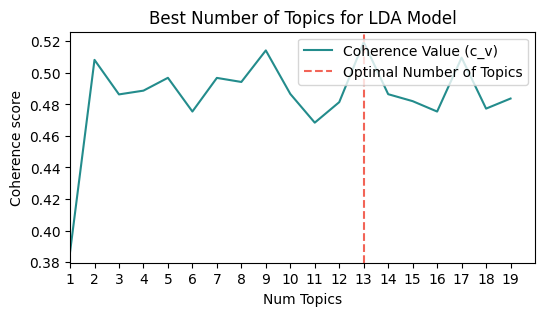

In [31]:
# Create chart of coherence value scores for different number of topics

# Create figure
plt.figure(figsize=(6,3))

# Create a custom x-axis
x = range(start_val, end_val, step_val)

# Build the line plot
ax = sns.lineplot(x=x, y=cv_score, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start_val, end_val)
plt.xticks(range(start_val, end_val, step_val))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(cv_score)],
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C',
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457',
                          ls='--', label='Optimal Number of Topics')]

# Add legend
ax.legend(handles=legend_elements, loc='upper right')

# 1d.  Coherence Scores for LDA - U_mass metric

In [32]:
# Compute Coherence Score --- U mass

# Create CoherenceModel
coherence_model_lda_umass = CoherenceModel(model=lda_model_simple, corpus=corpus, dictionary=dictionary, coherence='u_mass')

# Get coherence score
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
print('\nCoherence Score_UMass: ', coherence_lda_umass)


Coherence Score_UMass:  -0.9500333668749751


# 1d.  LDA Coherence Score - Calculate Umass sensitivity scores

In [33]:
coh_score = []
for i in range(start_val,end_val,step_val):
    lda_model_sense = models.LdaModel(corpus, id2word=dictionary, num_topics=i, passes=1)
    #coherence_model_lda_umass = CoherenceModel(model=lda_model_sense, texts=mins_dataset['tokenised_data'], dictionary=dictionary, coherence='u_mass')
    coherence_model_lda_umass = CoherenceModel(model=lda_model_sense, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    
    coherence_lda_umass = coherence_model_lda_umass.get_coherence()
    coh_score.append(coherence_lda_umass)
#coh_score

# 1d.  LDA Coherence Scores - Show Chart For Umass scores

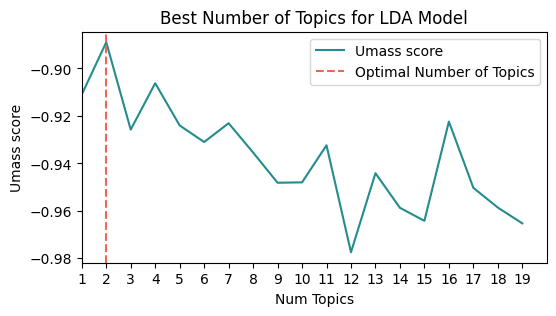

In [34]:
# Create chart showing Umass scores for different number of topics

# Create chart figure
plt.figure(figsize=(6,3))

# Create a custom x-axis
x = range(start_val, end_val, step_val)

# Build the line plot
ax = sns.lineplot(x=x, y=coh_score, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Umass score")
plt.xlim(start_val, end_val)
plt.xticks(range(start_val, end_val, step_val))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coh_score)],
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C',
                          ls='-', label='Umass score'),
                   Line2D([0], [1], color='#F26457',
                          ls='--', label='Optimal Number of Topics')]

# Show legend
ax.legend(handles=legend_elements, loc='upper right')

# 1d.  LDA Coherence Score - UCI

In [35]:
# Compute Coherence Score --- UCI
coherence_model_lda_uci = CoherenceModel(model=lda_model_simple, texts=texts, dictionary=dictionary, coherence='c_uci')
coherence_lda_uci = coherence_model_lda_uci.get_coherence()
print('\nCoherence Score_UCI: ', coherence_lda_uci)


Coherence Score_UCI:  -10.043783759741364


# 1d.  LDA Coherence Score - Perplexity

In [36]:
# Calculate perplexity
perplexity = lda_model_simple.log_perplexity(corpus)
print('\nPerspexity Score: ', perplexity) # Lower is better


Perspexity Score:  -9.343782875102166


# 1d.  LDA  - Calculate what % each doc contains of each topic (the vectors)

In [37]:
fomc_top2vec_mins = mins_dataset['Federal_Reserve_Mins']

In [38]:
# Create list for each doc showing what % of each topic that doc contains
top_vecs_train_mins = []
for i in range(len(fomc_top2vec_mins)):
    doc_topics = lda_model_simple.get_document_topics(corpus[i],minimum_probability=0.0)
    doc_top_vec = [doc_topics[num][1] for num in range(9)]
    top_vecs_train_mins.append(doc_top_vec)

In [39]:
# Show length of vectors list
print(len(top_vecs_train_mins))

123


In [40]:
# For most recent doc (the last one in the list), show what % is related to a given topic
top_vecs_train_mins[1]

# Check data type
#print(type(top_vecs_train_mins))

[0.63711977,
 0.00011907536,
 0.034395143,
 0.13411573,
 0.16939348,
 0.000119071374,
 0.00073811505,
 0.02388054,
 0.00011908025]

# 1d.  Create separate mini df w LDA vectors

In [41]:
# Put LDA vecs in df
LDA_vecs_df = pd.DataFrame(top_vecs_train_mins)

# Add column names
LDA_vecs_df.columns = ['LDA_1','LDA_2','LDA_3','LDA_4','LDA_5','LDA_6',
                      'LDA_7','LDA_8','LDA_9']

LDA_vecs_df.index = mins_dataset.index

# Add average column to df
#LDA_vecs_df['LDA_vec_avg'] = LDA_vecs_df.mean(axis=1)

# Add max col to df
LDA_vecs_df['LDA_max_value'] = LDA_vecs_df.max(axis=1)

# Review df
LDA_vecs_df.head(2)

,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,LDA_9,LDA_max_value
2008-01-30,0.376015,0.553198,0.000091,0.013554,0.024292,0.000091,0.000091,0.000091,0.032577,0.553198
2008-03-18,0.637120,0.000119,0.034395,0.134116,0.169393,0.000119,0.000738,0.023881,0.000119,0.637120


In [42]:
# Get shape of LDA vecs df
LDA_vecs_df.shape

(123, 10)

# 1d.  Create chart showing most commonly used words after LDA pre-processing

In [43]:
# Create counter to compile results from each document
master_counter = Counter()

# Loop through each doc and get Counter info
for i in range(len(texts)):
    new_counter_info = Counter(texts[i])
    # Add newest counter to master counter
    master_counter += new_counter_info

In [44]:
# Review most common words in combined counter
master_counter.most_common(15)

[('rate', 8344),
 ('inflation', 8017),
 ('Committee', 7953),
 ('market', 7458),
 ('participant', 7154),
 ('economic', 5516),
 ('price', 5142),
 ('policy', 4942),
 ('continue', 4706),
 ('increase', 4649),
 ('Federal', 4544),
 ('remain', 4454),
 ('Board', 4246),
 ('Reserve', 3997),
 ('condition', 3574)]

In [45]:
# Create new df to hold combined Counter results
counter_df = pd.DataFrame.from_records({'Value':master_counter})

# Sort counter df
sorted_counter_df = counter_df.sort_values(by='Value',ascending=False)

# Take subset of sorted counter df
subset = sorted_counter_df[0:15]
#subset

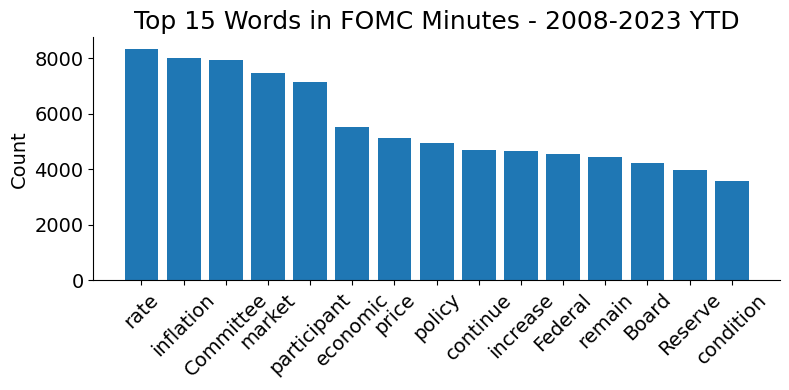

In [46]:
# Create a bar chart

# Create figure
plt.figure(figsize=(8, 4))

# Create bar chart
plt.bar(subset.index, subset['Value'])

# Add labels and format axis
plt.xticks(rotation = 45,fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.title("Top 15 Words in FOMC Minutes - 2008-2023 YTD",fontsize=18)
plt.tight_layout()

# Remove right and top borders
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)

# Display the bar chart
plt.show()

# 1e. Use BERTopic for Topic Modeling

In [47]:
# Create model
vectorizer_model = CountVectorizer(stop_words='english')
bert_model_mins = BERTopic(vectorizer_model=vectorizer_model,verbose=True)

In [48]:
# Access FOMC data
bert_data_mins = mins_dataset['Federal_Reserve_Mins'].to_list()
# Feed data into model
topics, probabilities = bert_model_mins.fit_transform(bert_data_mins)

Batches: 100%|████████████████████████████████████| 4/4 [00:20<00:00,  5.02s/it]
2023-08-11 13:31:09,193 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-08-11 13:31:18,112 - BERTopic - Reduced dimensionality
2023-08-11 13:31:18,152 - BERTopic - Clustered reduced embeddings


# 1e.  BERTopic - Show distribution of docs by topics

In [49]:
# Show how many documents are in each topic
bert_model_mins.get_topic_freq().head(10)

,Topic,Count
1,0,31
4,1,20
2,2,17
0,3,16
5,4,16
3,5,12
6,6,11


In [50]:
# Get info on each topic
bert_model_mins.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,31,0_federal_economic_market_inflation,"[federal, economic, market, inflation, committ...","[December 15-16, 2009 PRESENT: Mr. Ber..."
1,1,20,1_inflation_market_rate_federal,"[inflation, market, rate, federal, economic, p...","[The Federal Reserve, the central bank of the ..."
2,2,17,2_committee_economic_policy_federal,"[committee, economic, policy, federal, market,...","[The Federal Reserve, the central bank of the ..."
3,3,16,3_rate_inflation_participants_federal,"[rate, inflation, participants, federal, marke...","[The Federal Reserve, the central bank of the ..."
4,4,16,4_participants_market_federal_inflation,"[participants, market, federal, inflation, eco...","[The Federal Reserve, the central bank of the ..."
5,5,12,5_inflation_committee_market_rate,"[inflation, committee, market, rate, federal, ...","[The Federal Reserve, the central bank of the ..."
6,6,11,6_inflation_participants_board_policy,"[inflation, participants, board, policy, feder...","[The Federal Reserve, the central bank of the ..."


In [51]:
# Show keywords for a given topic
bert_model_mins.get_topic(0)

[('federal', 0.02870438234050486),
 ('economic', 0.027618573078499003),
 ('market', 0.025170640570125698),
 ('inflation', 0.02415460436525115),
 ('committee', 0.02371347898545883),
 ('prices', 0.02245595828799809),
 ('participants', 0.021887410688216535),
 ('financial', 0.02108947043859626),
 ('securities', 0.021007909445359862),
 ('markets', 0.02051126199345475)]

# 1e.  BERTopic-  get_document_info( ).  "Topic" column in df is similar to LDA vector output.

In [52]:
# Get more a in-depth summary info about each document
bert_outputs_mins_df = bert_model_mins.get_document_info(bert_data_mins)
bert_outputs_mins_df.index = mins_dataset.index
bert_outputs_mins_df.head(3)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
2008-01-30,"The Federal Reserve, the central bank of the U...",3,3_rate_inflation_participants_federal,"[rate, inflation, participants, federal, marke...","[The Federal Reserve, the central bank of the ...",rate - inflation - participants - federal - ma...,0.953971,True
2008-03-18,"March 18, 2008 Present:Mr. Bernanke, Chairman...",0,0_federal_economic_market_inflation,"[federal, economic, market, inflation, committ...","[December 15-16, 2009 PRESENT: Mr. Ber...",federal - economic - market - inflation - comm...,1.000000,False
2008-04-30,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...",0,0_federal_economic_market_inflation,"[federal, economic, market, inflation, committ...","[December 15-16, 2009 PRESENT: Mr. Ber...",federal - economic - market - inflation - comm...,1.000000,False


In [53]:
# Confirm length of bert_outputs_df
len(bert_outputs_mins_df)

123

In [54]:
# Review entries
bert_outputs_mins_df['Topic'].tail()

2022-12-14    6
2023-02-01    6
2023-03-22    6
2023-05-03    6
2023-06-14    6
Name: Topic, dtype: int64

In [55]:
# Show how many documents are considered representative
bert_outputs_mins_df['Representative_document'].value_counts()

Representative_document
False    102
True      21
Name: count, dtype: int64

In [56]:
# Show key words associated with each topic
bert_outputs_mins_df['Name'].value_counts()

Name
0_federal_economic_market_inflation        31
1_inflation_market_rate_federal            20
2_committee_economic_policy_federal        17
3_rate_inflation_participants_federal      16
4_participants_market_federal_inflation    16
5_inflation_committee_market_rate          12
6_inflation_participants_board_policy      11
Name: count, dtype: int64

In [57]:
# Visualize separation of topics
#bert_model_mins.visualize_documents(bert_data_mins)

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


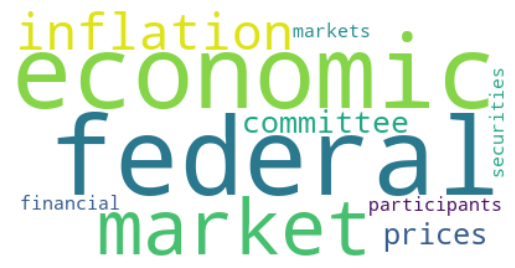

In [59]:
# Show wordcloud
create_wordcloud(bert_model_mins, topic=0)

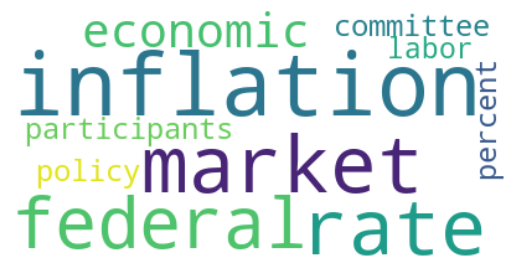

In [60]:
# Show wordcloud
create_wordcloud(bert_model_mins, topic=1)

# 1f.  Doc2Vec

In [61]:
# Create training data

# Retrieve data
data = mins_dataset["Federal_Reserve_Mins"]

# Create function to preprocess text and create tags (numbers) for each doc

def preprocess_and_tag(df_data,tokens_only=False):

    for i, line in enumerate(df_data):
        # Preprocess data
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # Add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens,[i])

# Put results in list -- to be fed into Doc2Vec model            
training_data  = list(preprocess_and_tag(data))

# 1f.  2 types of Doc2vec models - (1) param dm = 0 is Distributed Memory (PV-DM), like CBOW in Word2Vec, and (2) param dm = 1 is Distributed Bag of Words (PV-DBOW), like Skip-Gram in Word2Vec

In [62]:
# Instantiate model
model_gensim_docs = gensim.models.doc2vec.Doc2Vec(dm=0,vector_size=10,min_count=2, epochs=50)

In [63]:
# Build model vocabulary
model_gensim_docs.build_vocab(training_data)

In [64]:
# Train model on tagged docs
model_gensim_docs.train(training_data,total_examples=model_gensim_docs.corpus_count,epochs=model_gensim_docs.epochs)

In [65]:
# Create numerical vectors for each document

doc_vectors = []
for doc_id in range(len(training_data)):
    inferred_vector = model_gensim_docs.infer_vector(training_data[doc_id].words)
    doc_vectors.append(inferred_vector)

In [66]:
# Review first vector    
doc_vectors[0]

array([-1.0727857 , -0.92173976, -0.6188093 ,  1.0110458 , -0.47426772,
        0.02994507, -0.10156021, -1.4406023 , -0.1888434 ,  0.34580356],
      dtype=float32)

# 1f.  Create df with vectors from Doc2Vec model

In [67]:
# Put array of vectors into df
d2v_doc_vectors_df = pd.DataFrame(doc_vectors)

# Add column headers
d2v_doc_vectors_df.columns = ['d2v_1','d2v_2','d2v_3','d2v_4','d2v_5',
                             'd2v_6','d2v_7','d2v_8','d2v_9','d2v_10']


# Add index
d2v_doc_vectors_df.index = mins_dataset.index

# Add mean col for each row
d2v_doc_vectors_df['d2v_mean'] = d2v_doc_vectors_df.mean(axis=1)

# Get shape
print("Shape of d2v_doc_vectors_df", d2v_doc_vectors_df.shape)

# Show beginning of df
d2v_doc_vectors_df.tail(5)

Shape of d2v_doc_vectors_df (123, 11)


,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,d2v_10,d2v_mean
2022-12-14,-0.310470,-1.038953,-0.778548,0.623374,0.720895,0.313662,-0.005169,-0.889667,-0.567328,1.525583,-0.040662
2023-02-01,-0.397799,-0.866286,-0.952267,0.668278,0.647701,-0.061832,0.308297,-0.731752,-0.663975,1.616355,-0.043328
2023-03-22,-0.241766,-0.873768,-0.822453,0.708786,0.807386,0.328926,0.087645,-0.874434,-0.642256,1.475905,-0.004603
2023-05-03,-0.276798,-0.922021,-0.685028,0.620754,0.758912,0.427404,-0.166800,-0.863563,-0.598781,1.407864,-0.029806
2023-06-14,-0.178685,-0.824370,-0.807043,0.634225,0.891727,0.442698,0.080721,-0.759524,-0.732175,1.418520,0.016610


In [68]:
# Confirm shape of df
d2v_doc_vectors_df.shape

(123, 11)

# 1f.  Test the Doc2Vec model -- How often is a doc most similar to itself?

In [69]:
# Calculate ranks = shows how often a given doc is most similar to itself within the training data
ranks = []
second_ranks = []
for doc_id in range(len(training_data)):
    inferred_vector = model_gensim_docs.infer_vector(training_data[doc_id].words)
    sims = model_gensim_docs.dv.most_similar([inferred_vector], topn=len(model_gensim_docs.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

# 1f.  Show results - inferred vector vs training vector

In [70]:
# Show how many items in training data
print("Length of training data", len(training_data))

# Show rank data -- want 0:VALUE to be as close to length of training data as possible
counter_ranks = collections.Counter(ranks)
print("Ranks",counter_ranks)

Length of training data 123
Ranks Counter({0: 122, 1: 1})


# 1g.  Doc2Vec dim reduction using Umap, create df as an alternative to Doc2vec vectors above

Shape of umap_d2v_df (123, 2)


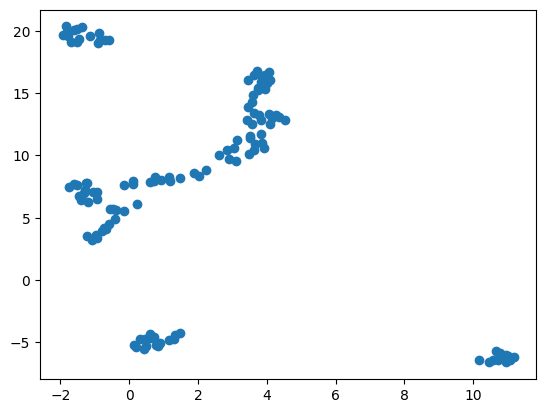

In [71]:
# Put array of vectors (excluding mean) into df
umap_df = pd.DataFrame(doc_vectors)

# Run UMAP to reduce number of dimensions
umap_d2v = umap.UMAP(random_state=0,n_neighbors=10, min_dist=0.3,
                    n_components=2).fit_transform(umap_df)

# Put UMAP results into another df
umap_d2v_df = pd.DataFrame(umap_d2v)

# Add column headers
umap_d2v_df.columns = ['d2v_umap_first_component','d2v_umap_second_component']

umap_d2v_df.index = mins_dataset.index

# Show first few results
umap_d2v_df.head()

# Show shape of df
print("Shape of umap_d2v_df",umap_d2v_df.shape)

# Visualize UMAP results
plt.scatter(umap_d2v[:,0],umap_d2v[:,1])

In [72]:
# Review Doc2Vec UMAP data
umap_d2v_df.head()

,d2v_umap_first_component,d2v_umap_second_component
2008-01-30,-0.572112,19.297571
2008-03-18,-1.186404,6.272410
2008-04-30,-0.943062,6.531765
2008-08-05,-1.744280,7.499795
2008-09-16,-1.590941,7.739094


# 2h.  Named Entity Recogntion

# 2h.  Run on single document

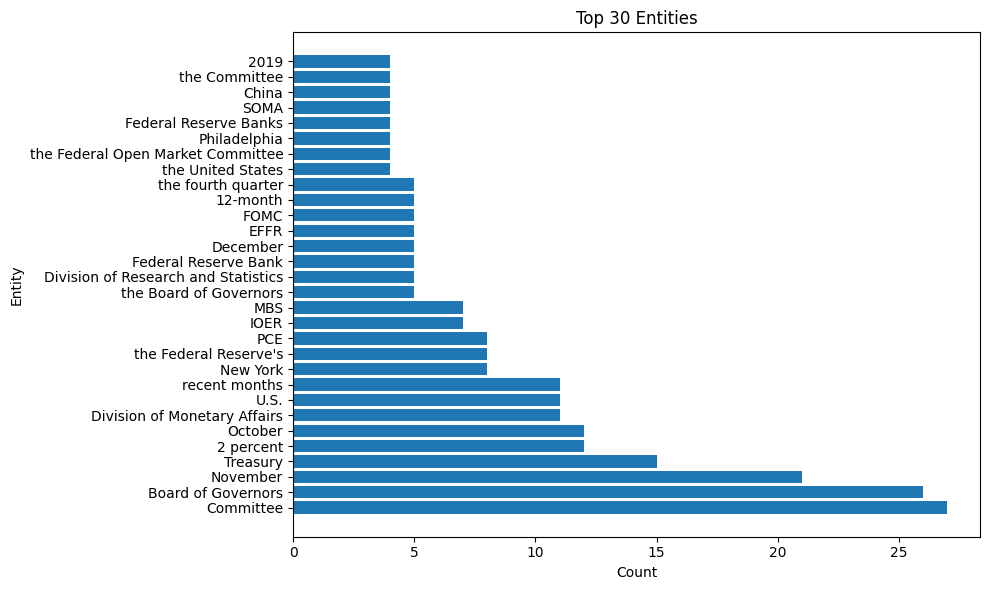

,Associate Director,Brexit,Jerome H. Powell,John C. Williams,Raphael W. Bostic,James A. Clouse,Counsel,Tools,Thomas I. Barkin,Michelle W. Bowman
0,3,3,2,2,2,2,2,1,1,1


In [73]:
# Load specific row
test_fomc = mins_dataset['Federal_Reserve_Mins'][0]

# Run it through NLP model
test_doc = nlp(test_fomc)

# Extract entities and count their occurrences
entities = [entity.text for entity in test_doc.ents]
entity_counts = Counter(entities)

# Get the top XX entities
top_xx_entities = entity_counts.most_common(30)

# Extract entity names and their counts
entity_names = [entity[0] for entity in top_xx_entities]
entity_count_values = [entity[1] for entity in top_xx_entities]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(entity_names, entity_count_values)
plt.xlabel("Count")
plt.ylabel("Entity")
plt.title("Top 30 Entities")
plt.tight_layout()

# Display the bar chart
plt.show()

# Extract top 10 people entities
people_entities = [entity.text for entity in test_doc.ents if entity.label_ == "PERSON"]
top_10_people_entities = Counter(people_entities).most_common(10)
top_10_people_entities

# Create df for indiv doc with people as cols and counts as values
d = defaultdict(list)
for a, b in top_10_people_entities:
    d[a].append(b)
top_10_people_df = pd.DataFrame(d)
top_10_people_df

# 2h. Create NER entity visualization of words in one of the docs

In [74]:
# Create NER ent diagram
from pathlib import Path

# Take subsample of test doc above
ner_sample_text = test_doc[209:302]

# Review
#ner_sample_text

# View sample of entities
html = displacy.render(ner_sample_text,style="ent")
html

# Output picture as web page
#serve = displacy.serve(ner_sample_text,style="ent",auto_select_port=True)
#serve

# 2h.  Create function to create NER PERSON df for all documents

In [75]:
# All in one function to create df of most commonly named people

# Create empty list to hold each indiv df
top_named_entities = []

# Create for loop to go through each doc
for i in mins_dataset['Federal_Reserve_Mins']:
    
    # Run through NLP model
    new_doc = nlp(i)
    
    # Extract all "PERSON" entries
    people_entities = [entity.text for entity in new_doc.ents if entity.label_ == "PERSON"]
    
    # Get top XX "PERSON" entities
    top_XX_people_entities = Counter(people_entities).most_common(5)
    
    # Create mini_df for each doc
    d = defaultdict(list)
    for a, b in top_XX_people_entities:
        d[a].append(b)
    top_XX_people_df = pd.DataFrame(d)
    
    # Add each mini_df to the list
    top_named_entities.append(top_XX_people_df)

# Combine all mini_dfs into one large df
ner_df = pd.concat(top_named_entities)

# Fill NaNs with 0
ner_df = ner_df.fillna(0)

# Set index to match dates in FOMC minutes data
ner_df.index = mins_dataset.index

In [76]:
# Review shape of newly created df
ner_df.shape

(123, 72)

In [77]:
# Review entries
ner_df.head()

,Associate Director,Brexit,Jerome H. Powell,John C. Williams,Raphael W. Bostic,Fisher,Plosser,Bernanke,Geithner,Yellen,...,YCT,FIMA,Thomas,Thomas Laubach,Chair Powell,COVID-19,Christopher J. Waller,Lisa D. Cook,Austan D. Goolsbee,Lorie K. Logan
2008-01-30,3.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-03-18,0.0,0.0,0.0,0.0,0.0,6.0,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-04-30,0.0,0.0,0.0,0.0,0.0,8.0,5.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-05,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# Review column names
ner_df.columns

Index(['Associate Director', 'Brexit', 'Jerome H. Powell', 'John C. Williams',
       'Raphael W. Bostic', 'Fisher', 'Plosser', 'Bernanke', 'Geithner',
       'Yellen', 'SecretaryMr', 'Lockhart', 'Cumming', 'GSE', 'KrosznerMs',
       'PianaltoMr', 'Associate Directors', 'MMIFF', 'MBS', 'Dudley',
       'Williams', 'Sack', 'Bid', 'Lacker', 'B. Any', 'Kohn', 'ChairmanMr',
       'Duke', 'William C. Dudley', 'James Bullard', 'Thomas M. Hoenig',
       'Hoenig', 'Ben Bernanke', 'Elizabeth Duke', 'Charles L. Evans',
       'Richard W. Fisher', 'Sandra Pianalto', 'Daniel K. Tarullo',
       'William B. English', 'Charles I. Plosser', 'Loretta J. Mester',
       'Janet L. Yellen', 'Narayana Kocherlakota', 'Kocherlakota',
       'Senior Adviser', 'Stanley Fischer', 'Brian F. Madigan',
       'Patrick Harker', 'Tools', 'Mester', 'Counsel', 'Jeffrey M. Lacker',
       'Kashkari', 'Mark L. Mullinix', 'Hurricanes Harvey', 'Irma', 'Maria',
       'Randal K. Quarles', 'James A. Clouse', 'Esther L. 

In [79]:
# Confirm length of combined_df
len(ner_df)

123

In [80]:
# Save NER PERSON DataFrame to CSV file
ner_df.to_csv('NLP_FOMC_people_NEW_TEST_DATE.csv', index=True)

In [81]:
# Download of NER csv file and review
test_fomc_people = pd.read_csv('NLP_FOMC_people_NEW_TEST_DATE.csv',index_col=0)
test_fomc_people.tail()

,Associate Director,Brexit,Jerome H. Powell,John C. Williams,Raphael W. Bostic,Fisher,Plosser,Bernanke,Geithner,Yellen,...,YCT,FIMA,Thomas,Thomas Laubach,Chair Powell,COVID-19,Christopher J. Waller,Lisa D. Cook,Austan D. Goolsbee,Lorie K. Logan
2022-12-14,6.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2023-02-01,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2023-03-22,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2023-05-03,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
2023-06-14,4.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


# 2h.  NER - Analyze counts of select Chairs and known Hawkish and Dovish members

# Dovish members

In [82]:
# How many combined mentions of a person?
ner_df['Raphael W. Bostic'].sum()

32.0

# Hawkish members

In [83]:
# How many combined mentions of a person?
ner_df['James Bullard'].sum()

28.0

# Centrists & Chairs

In [84]:
# How many combined mentions of a person?
ner_df['Bernanke'].sum()

39.0

In [85]:
# How many combined mentions of a person?
ner_df['Ben Bernanke'].sum()

66.0

In [86]:
# How many combined mentions of a person?
ner_df['John C. Williams'].sum()

85.0

In [87]:
# How many combined mentions of a person?
ner_df['Jerome H. Powell'].sum()

133.0

In [88]:
# How many combined mentions of a person?
ner_df['Janet L. Yellen'].sum()

30.0

# 2i.  Create consolidated CSV file of output -- All metrics except USE scores and Named Entities

In [89]:
# Create new df with selected NLP outputs

# Create base df with original FOMC Minutes and Cosine Similarity
base_df = pd.concat([mins_dataset['Federal_Reserve_Mins'],mins_dataset['cosine_sim']],axis=1)

# Add BERTopic topic assignment to df
base_df['bertopic_num'] = bert_outputs_mins_df['Topic']

# Merge in LDA vectors df
lda_df = base_df.merge(LDA_vecs_df,left_index=True,right_index=True)

# Merge in Doc2Vec df    
d2v_df = lda_df.merge(d2v_doc_vectors_df,left_index=True,right_index=True)

# Merge in UMAP Doc2Vec df
final_df = d2v_df.merge(umap_d2v_df,left_index=True,right_index=True)

# Drop FOMC Minutes from ddf
final_df.drop(['Federal_Reserve_Mins'],axis=1,inplace=True)

# Review first few entries
final_df.head()

,cosine_sim,bertopic_num,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,...,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,d2v_10,d2v_mean,d2v_umap_first_component,d2v_umap_second_component
2008-01-30,0.000000,3,0.376015,0.553198,0.000091,0.013554,0.024292,0.000091,0.000091,0.000091,...,1.011046,-0.474268,0.029945,-0.101560,-1.440602,-0.188843,0.345804,-0.343181,-0.572112,19.297571
2008-03-18,0.647596,0,0.637120,0.000119,0.034395,0.134116,0.169393,0.000119,0.000738,0.023881,...,0.923967,0.895274,0.691911,0.966539,-0.039956,-1.344442,-0.430589,-0.015524,-1.186404,6.272410
2008-04-30,0.819067,0,0.999514,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000087,...,0.847409,0.943286,0.868339,0.643526,-0.025650,-1.314379,-0.377073,-0.008500,-0.943062,6.531765
2008-08-05,0.744683,0,0.884064,0.000147,0.000147,0.035253,0.001253,0.000147,0.078697,0.000147,...,0.786559,1.034716,1.621813,0.455797,-0.341665,-1.196640,-0.520343,0.025960,-1.744280,7.499795
2008-09-16,0.797560,0,0.923850,0.000160,0.000160,0.000160,0.004340,0.000160,0.070849,0.000160,...,0.851336,1.026119,1.922237,0.429004,-0.496180,-1.177531,-0.547455,0.031906,-1.590941,7.739094


In [90]:
# Confirm shape of final df
final_df.shape

(123, 25)

In [91]:
# Save Final df to CSV file
final_df.to_csv('NLP_output_NEW_TEST_DATE.csv', index=True)

In [92]:
# Test import of csv file
test_final_df = pd.read_csv('NLP_output_NEW_TEST_DATE.csv',index_col=0)
test_final_df.head()

,cosine_sim,bertopic_num,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,...,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,d2v_10,d2v_mean,d2v_umap_first_component,d2v_umap_second_component
2008-01-30,0.000000,3,0.376015,0.553198,0.000091,0.013554,0.024292,0.000091,0.000091,0.000091,...,1.011046,-0.474268,0.029945,-0.101560,-1.440602,-0.188843,0.345804,-0.343181,-0.572112,19.297571
2008-03-18,0.647596,0,0.637120,0.000119,0.034395,0.134116,0.169393,0.000119,0.000738,0.023881,...,0.923968,0.895274,0.691911,0.966539,-0.039956,-1.344442,-0.430589,-0.015524,-1.186404,6.272410
2008-04-30,0.819067,0,0.999514,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000087,...,0.847409,0.943285,0.868339,0.643526,-0.025650,-1.314379,-0.377073,-0.008500,-0.943062,6.531765
2008-08-05,0.744683,0,0.884064,0.000147,0.000147,0.035253,0.001253,0.000147,0.078697,0.000147,...,0.786559,1.034716,1.621813,0.455797,-0.341665,-1.196640,-0.520343,0.025960,-1.744280,7.499795
2008-09-16,0.797560,0,0.923850,0.000160,0.000160,0.000160,0.004340,0.000160,0.070849,0.000160,...,0.851336,1.026119,1.922237,0.429004,-0.496180,-1.177531,-0.547455,0.031906,-1.590941,7.739094


In [93]:
# Confirm shape of df
test_final_df.shape

(123, 25)

# Dependencies

In [94]:
# Dependencies for requirements file

!python -V
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("FedTools:", "0.07")
print("NLTK:", nltk.__version__)
print("Gensim:", gensim.__version__)
print("pyLDAvis:", pyLDAvis.__version__)
print("sklearn:", sklearn.__version__)
print("top2vec:", top2vec.__version__)
print("bertopic:", bertopic.__version__)
print("umap:", umap.__version__)
print("spaCy:", spacy.__version__)
print("re:", re.__version__)

Python 3.8.3
Pandas: 2.0.0
Numpy: 1.23.5
Matplotlib: 3.7.1
Seaborn: 0.12.2
FedTools: 0.07
NLTK: 3.8.1
Gensim: 4.3.1
pyLDAvis: 3.4.0
sklearn: 1.2.2
top2vec: 1.0.29
bertopic: 0.15.0
umap: 0.5.3
spaCy: 3.5.4
re: 2.2.1
